In [1]:
#import
import os
import sys
import numpy as np
import tensorflow as tf
import sklearn
import glob
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.metrics import *
from sklearn.preprocessing import OneHotEncoder

from stego_classifier_extended import *
import random as rn

In [20]:
#Utils

def extract_1_lsb_features(dataset):
    lsb_training_set = dataset & 1
    lsb_training_set = lsb_training_set.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2]*dataset.shape[3])
    return lsb_training_set

#convert to binary
def messageToBinary(message):
  if type(message) == str:
    return ''.join([ format(ord(i), "08b") for i in message ])
  elif type(message) == bytes or type(message) == np.ndarray:
    return [ format(i, "08b") for i in message ]
  elif type(message) == int or type(message) == np.uint8:
    return format(message, "08b")
  else:
    raise TypeError("Input type not supported")
  
#extract k lsb for each channel
def extract_k_lsb_features(data, k=4):
    count = 0
    lsb_training = []
    for img in data:
        count = count + 1
        if count % 1000 == 0:
            print(count)
        binary_data = []
        for values in img:
            for pixel in values:
                r, g, b = messageToBinary(pixel)
                for i in range(1,k+1):
                    binary_data.append(int(r[-1-i+1]))  # extracting data from the least significant bit of red pixel
                    binary_data.append(int(g[-1-i+1]))  # extracting data from the least significant bit of green pixel
                    binary_data.append(int(b[-1-i+1]))  # extracting data from the least significant bit of blue pixel
                # split by 8-bits

        lsb_training.append(np.array(binary_data))
        

    return np.array(lsb_training)

# load images in the image_path
def load_images(image_path):
    images = []
    for f_name in sorted(glob.glob(image_path + '/*.png')):
        img = np.asarray(Image.open(f_name).convert('RGB'))
        images.append(img)
    return images

#convert an image into array
def convert_np_array(vector):
    result = []
    for v in vector:
        result.append(v)
    return np.array(result)

#laod data
def load_data(main_data_folder, usage_folder_name, legit_folder_name, stego_folder_names):
    
    data_path = os.path.join(main_data_folder, usage_folder_name)
    data_to_load = []
    num_stego_images_for_class = []
    data_to_load.append(convert_np_array(load_images(os.path.join(data_path,legit_folder_name))))
    for stego_folder_name in stego_folder_names:
        stego_images = convert_np_array(load_images(os.path.join(data_path,stego_folder_name)))
        num_stego_images_for_class.append(stego_images.shape[0])
        data_to_load.append(stego_images)

    num_legit_images = data_to_load[0].shape[0]
    print("#legit images", data_to_load[0].shape[0])
    print("#stego images", num_stego_images_for_class)

    data_to_load = np.concatenate(data_to_load)
    print("data shape: ", data_to_load.shape)

    print("done")
    
    return data_to_load, num_legit_images, np.array(num_stego_images_for_class)

#create target variable with labels
def create_target_labels(legits, stego_type_number):
    target = []
    i = 0
    target.append(np.zeros(legits, dtype=np.int8))
    for current_stego in stego_type_number:
        target.append(np.ones(current_stego, dtype=np.int8)+i)
        i=i+1
    return np.concatenate(target)


def refresh_riproducibility(seed):
   
    #set seed 

    #Python SEED
    os.environ['PYTHONHASHSEED'] = '0'
    
    #numpy seed
    np.random.seed(seed)
    
    #tf seed
    tf.random.set_seed(seed)
    
    #rn seed
    rn.seed(seed)
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    #
    from tensorflow.compat.v1.keras import backend as K
    
    #sess
    sess = tf.compat.v1.get_default_session()
    K.set_session(sess)
    
    #tf seed
    tf.compat.v1.set_random_seed(seed)
    
    #os.environ['KERAS_BACKEND'] = "tensorflow"
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
def plot_roc_curve(fpr, tpr, title, area, set_title=True ):
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % area )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if set_title:
        plt.title(title)
    plt.legend(loc="lower right")

    
    return fig
    
def plot_aucpr_curve(recall, precision, title, area):
    fig = plt.figure()
    lw = 2
    plt.plot(recall, precision, color='blue',
             lw=lw, label='AUC-PR curve (area = %0.3f)' % area )
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")

    return plt

In [3]:
#Parameters ---------------------------

#data_folder =  "/" # Debug data folder: "./data/debug"

data_folder = "./Dataset/dataset"
legit_folder = 'legit'
#stego_folders = ['LSB_stego_php','LSB_stego_url']
stego_folders = ['LSB_stego_url','LSB_stego_eth','LSB_stego_html','LSB_stego_js','LSB_stego_ps']
cwd = './'
model_space = 'output/models-separate_k1'
seed = 230782
k_lsb = 1
epochs = 20
#------------------------------------

## Stego Malware Classification task

In [4]:
#loading training set
training_set, num_training_legit, num_training_stego_for_class  = load_data(data_folder, "training", legit_folder, stego_folders)
num_training_stego = np.sum(num_training_stego_for_class)
num_targets = len(num_training_stego_for_class)+1
print("#training shape, neg, pos: ", training_set.shape, num_training_legit, num_training_stego)
print("#num classes: ", num_targets)

ohe_processer = OneHotEncoder(handle_unknown='ignore')

#legit images 4000
#stego images [2412, 2473, 2284, 2363, 2468]
data shape:  (16000, 512, 512, 3)
done
#training shape, neg, pos:  (16000, 512, 512, 3) 4000 12000
#num classes:  6


In [5]:
#lsb extraction
#training_set = extract_k_lsb_features(training_set, k_lsb)
training_set = extract_1_lsb_features(training_set)

#create target
y_train = create_target_labels(num_training_legit, num_training_stego_for_class) 
print("#num examples for class:")
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print("Apply OHE")
ohe_processer = OneHotEncoder(handle_unknown='ignore')
ohe_y_train = ohe_processer.fit_transform(np.reshape(y_train,(-1,1))).toarray()
print("training set ready")

#num examples for class:
[[   0 4000]
 [   1 2412]
 [   2 2473]
 [   3 2284]
 [   4 2363]
 [   5 2468]]
Apply OHE
training set ready


In [6]:
#loading validation set
validation, num_val_legit, num_val_stego_for_class  = load_data(data_folder, "validation", legit_folder, stego_folders)
num_val_stego = np.sum(num_val_stego_for_class)
print("#validation shape, neg, pos: ", validation.shape, num_val_legit, num_val_stego)

#lsb extraction
#validation = extract_k_lsb_features(validation, k_lsb)
validation = extract_1_lsb_features(validation)

#create target
y_val = create_target_labels(num_val_legit, num_val_stego_for_class)
print("#num examples for class:")
(unique, counts) = np.unique(y_val, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print("Apply OHE")
ohe_y_val = ohe_processer.transform(np.reshape(y_val,(-1,1))).toarray()
print("validation set ready")

#legit images 2000
#stego images [1218, 1193, 1162, 1214, 1213]
data shape:  (8000, 512, 512, 3)
done
#validation shape, neg, pos:  (8000, 512, 512, 3) 2000 6000
#num examples for class:
[[   0 2000]
 [   1 1218]
 [   2 1193]
 [   3 1162]
 [   4 1214]
 [   5 1213]]
Apply OHE
validation set ready


In [7]:
#init classifier
#classifier = StegoClassifierExtended(training_set.shape[1], num_targets)

#compile classifier
#classifier.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])

#init callbacks
#model_path = os.path.join(cwd, model_space, 'best_model_stego_classification')
#print("best model path: ", model_path)
#check = ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')


In [8]:
#model_path = os.path.join(cwd, model_space, 'best_model_stego_classification')
#print("best model path: ", model_path)
#check = ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
#opt = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=1e-9, factor=0.01, verbose=0)

In [ ]:
import time

refresh_riproducibility(seed)

#init classifier
classifier = StegoClassifierExtended(training_set.shape[1], num_targets,  drop_pcg=0.025)

#compile classifier
classifier.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])

model_path = os.path.join(cwd, model_space, 'best_model_stego_classification')
print("best model path: ", model_path)
check = ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
opt = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=1e-9, factor=0.01, verbose=0)




start_time = int(round(time.time() * 1000))

#training model
history = classifier.fit(training_set, ohe_y_train, batch_size=256, epochs=epochs, 
                         validation_data=(validation, ohe_y_val), callbacks=[check, opt], verbose=1)

end_time = int(round(time.time() * 1000))
total_time = end_time - start_time
#print(start_time)
#print(end_time)
print('Total Training Time:'+str(total_time))



best model path:  ./output/models-separate_k1/best_model_stego_classification


2022-06-10 17:37:21.161343: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-10 17:37:21.161383: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: b44220ace66e
2022-06-10 17:37:21.161391: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: b44220ace66e
2022-06-10 17:37:21.161489: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-06-10 17:37:21.161624: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-10 17:37:21.161634: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-06-10 17:37:21.161881: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instr

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 1.1393 - accuracy: 0.5139

2022-06-10 17:43:25.552211: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6291456000 exceeds 10% of free system memory.
2022-06-10 17:43:26.574003: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6291456000 exceeds 10% of free system memory.


63/63 [==============================] - 381s 6s/step - loss: 1.1393 - accuracy: 0.5139 - val_loss: 1.3216 - val_accuracy: 0.5015 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.8573 - accuracy: 0.5989

2022-06-10 17:49:26.263548: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6291456000 exceeds 10% of free system memory.


63/63 [==============================] - 359s 6s/step - loss: 0.8573 - accuracy: 0.5989 - val_loss: 1.1263 - val_accuracy: 0.5440 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - 357s 6s/step - loss: 0.7353 - accuracy: 0.6455 - val_loss: 0.8361 - val_accuracy: 0.6252 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 359s 6s/step - loss: 0.6510 - accuracy: 0.6883 - val_loss: 0.8607 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 5/20
63/63 [==============================] - 356s 6s/step - loss: 0.5652 - accuracy: 0.7396 - val_loss: 0.7286 - val_accuracy: 0.6614 - lr: 0.0010
Epoch 6/20
63/63 [==============================] - 356s 6s/step - loss: 0.4857 - accuracy: 0.7814 - val_loss: 0.5675 - val_accuracy: 0.7473 - lr: 0.0010
Epoch 7/20
63/63 [==============================] - 361s 6s/step - loss: 0.4154 - accuracy: 0.8166 - val_loss: 0.6942 - val_accuracy: 0.7211 - lr: 0.0010
Epoch 8/20
63/63 [==============================] - 357s 6s/step - loss: 0.3528 - accur

Total Prediction Time:360956 \n
Total Prediction Time:445351 
--------------------------------
Total Prediction Time:383511
Total Prediction Time:483368

In [10]:
type(history.history)
his = history.history['loss']
val_loss = history.history['val_loss']
df_his = pd.DataFrame(data=his, columns=["Loss"])
df_his['epoch'] = range(1, len(df_his) + 1)
df_his['val_loss'] = val_loss
print(df_his)
df_his.to_csv('./output/history.csv', index=False)

        Loss  epoch  val_loss
0   1.139337      1  1.321560
1   0.857311      2  1.126327
2   0.735350      3  0.836098
3   0.651032      4  0.860718
4   0.565245      5  0.728574
5   0.485718      6  0.567537
6   0.415446      7  0.694178
7   0.352753      8  1.323436
8   0.303828      9  0.627985
9   0.227119     10  0.367388
10  0.194705     11  0.332815
11  0.177343     12  0.320971
12  0.162123     13  0.315194
13  0.152121     14  0.312225
14  0.146978     15  0.309972
15  0.139537     16  0.308567
16  0.133524     17  0.311027
17  0.129107     18  0.311295
18  0.124254     19  0.313924
19  0.119972     20  0.314716


/home/bmsa/env-max/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/bmsa/env-max/lib/python3.8/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


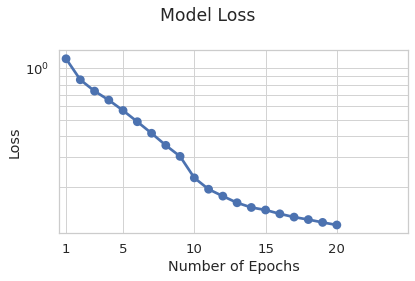

In [11]:
import seaborn as sns
#print history loss
sns.set()
sns.set(style='whitegrid', font_scale = 1.2)
#sns.set_style("darkgrid")
#sns.set_context("paper")

rc = {'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      #'font.family':'Times New Roman',
      'font.height' : 16}
#plt.rcParams.update(rc)
#sns.set(font_scale = 1.1)

g = sns.factorplot(x ='epoch', y ='Loss', data = df_his,
               legend_out = False, size=4, aspect=1.5)
g.set(yscale='log')
#g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Model Loss')

g.axes[0,0].set_xlabel('Number of Epochs')
plt.xticks([0,4,9,14,19,24]) 
plt.grid(True, which="both",ls="-",c='#D3D3D3')
sns.despine(bottom = False, left = False, right=False, top=False)

new_labels = ['Stego Classifier']
plt.tight_layout() 

plt.savefig('output/training_loss.pdf')

/home/bmsa/env-max/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/bmsa/env-max/lib/python3.8/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


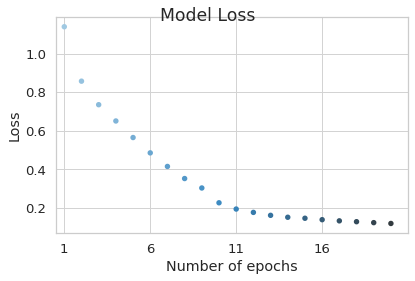

In [12]:
g = sns.factorplot(x='epoch', y="Loss", linestyles=["-", "--","-", "--"], markers=['.','x','v','+'], 
                   palette="Blues_d", legend_out = False, data=df_his, size=4, aspect=1.5)
type(g)

g.fig.suptitle('Model Loss')

g.axes[0,0].set_xlabel('Number of epochs')
plt.xticks([0, 5, 10, 15, 20]) 
plt.grid(True, which="both",ls="-",c='#D3D3D3') 
sns.despine(bottom = False, left = False, right=False, top=False)



new_labels = ['Stego Classifier']
#for t, l in zip(g._legend.texts, new_labels):
#    t.set_text(l)


In [13]:
g.fig.set_title("Plot", fontsize = 20)
g.set_xlabel("Number of epoch")
#g.set_ylabel("loss", fontsize = 20)
#g.set_title("Plot", fontsize = 20)

#g.fig.get_axes()[0].set_yscale('log')
plt.xticks([0, 5, 10, 15, 20]) 
plt.grid(True, which="both",ls="-",c='#D3D3D3') 
sns.despine(bottom = False, left = False, right=False, top=False)
g.set_xlabels("Number of epochs")

#g._legend.set_title("")
new_labels = ['Stego Classifier']
#for t, l in zip(g._legend.texts, new_labels):
#    t.set_text(l)

plt.tight_layout() 

plt.savefig('output/training_loss.pdf')

AttributeError: 'Figure' object has no attribute 'set_title'

In [14]:
#reload best model
classifier.load_weights(model_path)

In [15]:
#loading test set plain
test, num_test_legit, num_test_stego_for_class  = load_data(data_folder, "test_plain", legit_folder, stego_folders)
num_test_stego = np.sum(num_test_stego_for_class)
print("#test shape, neg, pos: ", test.shape, num_test_legit, num_test_stego)

#lsb extraction
#test = extract_k_lsb_features(test, k_lsb)
test = extract_1_lsb_features(test)

#create target
y_test = create_target_labels(num_test_legit, num_test_stego_for_class)
print("#num examples for class:")
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print("Apply OHE")
ohe_y_test = ohe_processer.transform(np.reshape(y_test,(-1,1))).toarray()
print("test set ready")

#legit images 2000
#stego images [1234, 1247, 1167, 1188, 1164]
data shape:  (8000, 512, 512, 3)
done
#test shape, neg, pos:  (8000, 512, 512, 3) 2000 6000
#num examples for class:
[[   0 2000]
 [   1 1234]
 [   2 1247]
 [   3 1167]
 [   4 1188]
 [   5 1164]]
Apply OHE
test set ready


In [40]:
test.shape[0]

8000

In [45]:

start_time = int(round(time.time() * 1000))

y_pred_score = classifier.predict(test)

end_time = int(round(time.time() * 1000))
total_time = end_time - start_time
#print(start_time)
#print(end_time)
print('Total Prediction Time:'+str(total_time))
single_prediction_time = total_time/test.shape[0]
print('Single Prediction Time:'+str(single_prediction_time))

y_pred_label = np.around(y_pred_score, 0)

report_map = classification_report(y_test, np.argmax(y_pred_score, axis=1), output_dict=True)

acc_score = accuracy_score(ohe_y_test, y_pred_label)

auc_score = roc_auc_score(ohe_y_test, y_pred_score, multi_class="ovr", average="macro")

auc_score_pr = average_precision_score(ohe_y_test, y_pred_score)

result = str(acc_score)+";"+str(report_map['macro avg']['precision']) + ";" + str(
        report_map['macro avg']['recall']) + ";" + str(report_map['macro avg']['f1-score']) + ";" + str(
        auc_score)  + ";" + str(auc_score_pr)
 
print("acc;prec;rec;f1;auc;auc-pr")
print(result)

250/250 [==============================] - 42s 105ms/step
Total Prediction Time:50648
Single Prediction Time:6.331
acc;prec;rec;f1;auc;auc-pr
0.486875;0.46882119619594764;0.4375588019232219;0.3237920820227253;0.7044973519504832;0.3575581211891427


/home/bmsa/env-max/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bmsa/env-max/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bmsa/env-max/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
auc_all_class = roc_auc_score(ohe_y_test, y_pred_score, multi_class="ovr", average=None)
print(auc_all_class)

[0.99975317 0.5172206  0.49612189 0.64738853 0.8889778  0.67752212]


In [18]:
auc_pr0 = average_precision_score(ohe_y_test[:,0], y_pred_score[:,0])
auc_pr1 = average_precision_score(ohe_y_test[:,1], y_pred_score[:,1])
auc_pr2 = average_precision_score(ohe_y_test[:,2], y_pred_score[:,2])
auc_pr3 = average_precision_score(ohe_y_test[:,3], y_pred_score[:,3])
auc_pr4 = average_precision_score(ohe_y_test[:,4], y_pred_score[:,4])
auc_pr5 = average_precision_score(ohe_y_test[:,5], y_pred_score[:,5])
print(str(auc_pr0)+" "+str(auc_pr1)+" "+str(auc_pr2)+" "+str(auc_pr3)+" "+str(auc_pr4)+" "+str(auc_pr5))

0.9988226437402842 0.5256469479554513 0.5083500956554189 0.995341690104179 0.9940544873816762 0.9986302028156597


(8000, 6)
[9.6776652e-01 3.0016534e-02 2.1578926e-03 2.3035185e-05 1.1625248e-05
 2.4248444e-05]
(8000, 6)


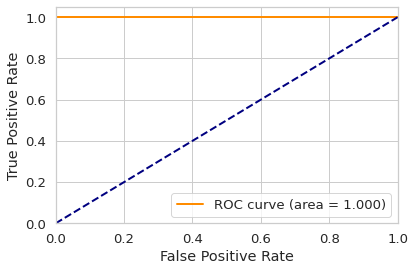

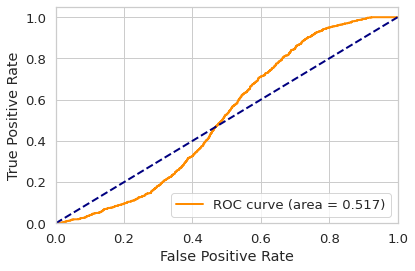

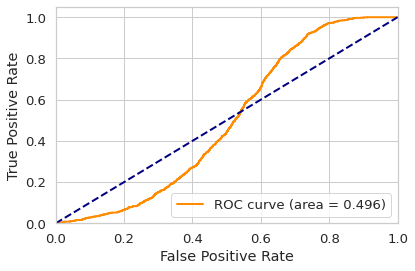

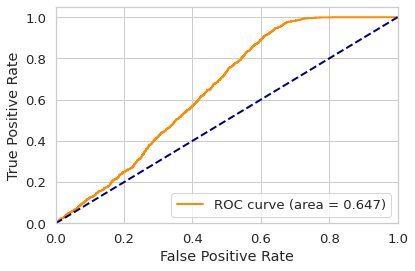

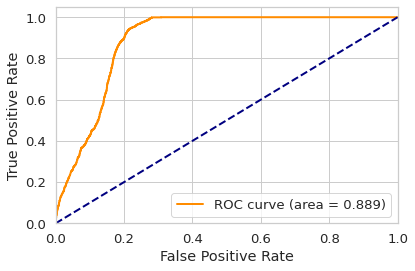

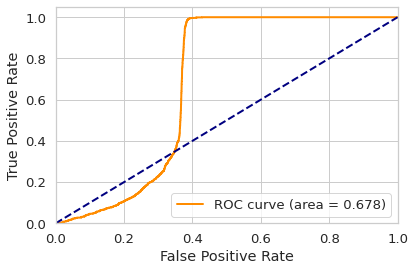

In [34]:
import sklearn.metrics as metrics
print(y_pred_score.shape)
print(y_pred_score[0])
print(ohe_y_test.shape)
ohe_y_test[0]
fpr0, tpr0, threshold0 = metrics.roc_curve(ohe_y_test[:,0], y_pred_score[:,0])
#tpr.shape
fig0 = plot_roc_curve(fpr0,tpr0,'Receiver Operating Characteristic Class Legit', auc_all_class[0], set_title = False)

fpr1, tpr1, threshold1 = metrics.roc_curve(ohe_y_test[:,1], y_pred_score[:,1])
fig1 = plot_roc_curve(fpr1,tpr1,'Receiver Operating Characteristic Class Stego-URL', auc_all_class[1], set_title = False)

fpr2, tpr2, threshold2 = metrics.roc_curve(ohe_y_test[:,2], y_pred_score[:,2])
fig2 = plot_roc_curve(fpr2,tpr2,'Receiver Operating Characteristic Class Stego-ETH', auc_all_class[2], set_title = False)

fpr3, tpr3, threshold3 = metrics.roc_curve(ohe_y_test[:,3], y_pred_score[:,3])
fig3 = plot_roc_curve(fpr3,tpr3,'Receiver Operating Characteristic Class Stego-HTML', auc_all_class[3], set_title = False)

fpr4, tpr4, threshold4 = metrics.roc_curve(ohe_y_test[:,4], y_pred_score[:,4])
fig4 = plot_roc_curve(fpr4,tpr4,'Receiver Operating Characteristic Class Stego-JS', auc_all_class[4], set_title = False)

fpr5, tpr5, threshold5 = metrics.roc_curve(ohe_y_test[:,5], y_pred_score[:,5])
fig5 = plot_roc_curve(fpr5,tpr5,'Receiver Operating Characteristic Class Stego-PS', auc_all_class[5], set_title = False)

fig0.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
fig4.tight_layout()
fig5.tight_layout()

fig0.savefig('./figure/roc_plain_class_legit.pdf')
fig1.savefig('./figure/roc_plain_class_stego_url.pdf')
fig2.savefig('./figure/roc_plain_class_stego_eth.pdf')
fig3.savefig('./figure/roc_plain_class_stego_html.pdf')
fig4.savefig('./figure/roc_plain_class_stego_js.pdf')
fig5.savefig('./figure/roc_plain_class_stego_ps.pdf')

In [24]:
#loading test set b64
test, num_test_legit, num_test_stego_for_class  = load_data(data_folder, "test_b64", legit_folder, stego_folders)
num_test_stego = np.sum(num_test_stego_for_class)
print("#test shape, neg, pos: ", test.shape, num_test_legit, num_test_stego)

#lsb extraction
#test = extract_k_lsb_features(test, k_lsb)
test = extract_1_lsb_features(test)

#create target
y_test = create_target_labels(num_test_legit, num_test_stego_for_class)
print("#num examples for class:")
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print("Apply OHE")
ohe_y_test = ohe_processer.transform(np.reshape(y_test,(-1,1))).toarray()
print("test set ready")

#legit images 2000
#stego images [1234, 1247, 1167, 1188, 1164]
data shape:  (8000, 512, 512, 3)
done
#test shape, neg, pos:  (8000, 512, 512, 3) 2000 6000
#num examples for class:
[[   0 2000]
 [   1 1234]
 [   2 1247]
 [   3 1167]
 [   4 1188]
 [   5 1164]]
Apply OHE
test set ready


In [25]:
y_pred_score = classifier.predict(test)

y_pred_label = np.around(y_pred_score, 0)

report_map = classification_report(y_test, np.argmax(y_pred_score, axis=1), output_dict=True)

acc_score = accuracy_score(ohe_y_test, y_pred_label)

auc_score = roc_auc_score(ohe_y_test, y_pred_score, multi_class="ovr", average="macro")

auc_score_pr = average_precision_score(ohe_y_test, y_pred_score)

result = str(acc_score)+";"+str(report_map['macro avg']['precision']) + ";" + str(
        report_map['macro avg']['recall']) + ";" + str(report_map['macro avg']['f1-score']) + ";" + str(
        auc_score)  + ";" + str(auc_score_pr)
 
print("acc;prec;rec;f1;auc;auc-pr")
print(result)

250/250 [==============================] - 42s 159ms/step
acc;prec;rec;f1;auc;auc-pr
0.68275;0.7024974145504631;0.6702206532691645;0.6610728351487011;0.8860466174528789;0.6274275764545408


In [26]:
auc_all_class = roc_auc_score(ohe_y_test, y_pred_score, multi_class="ovr", average=None)
print(auc_all_class)

[0.99948833 0.89779158 0.901233   0.97053835 0.90327255 0.64395589]


In [27]:
auc_pr0 = average_precision_score(ohe_y_test[:,0], y_pred_score[:,0])
auc_pr1 = average_precision_score(ohe_y_test[:,1], y_pred_score[:,1])
auc_pr2 = average_precision_score(ohe_y_test[:,2], y_pred_score[:,2])
auc_pr3 = average_precision_score(ohe_y_test[:,3], y_pred_score[:,3])
auc_pr4 = average_precision_score(ohe_y_test[:,4], y_pred_score[:,4])
auc_pr5 = average_precision_score(ohe_y_test[:,5], y_pred_score[:,5])
print(str(auc_pr0)+" "+str(auc_pr1)+" "+str(auc_pr2)+" "+str(auc_pr3)+" "+str(auc_pr4)+" "+str(auc_pr5))

0.99906743793536 0.4752381904447634 0.4737617902791754 0.8150604202775298 0.4919080118843696 0.5095296079060472


(8000, 6)
[9.6776652e-01 3.0016534e-02 2.1578926e-03 2.3035185e-05 1.1625248e-05
 2.4248444e-05]
(8000, 6)


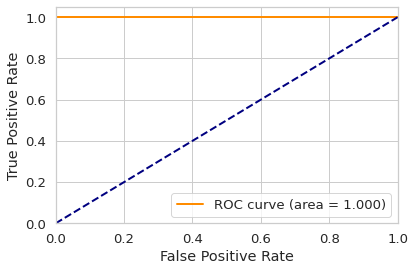

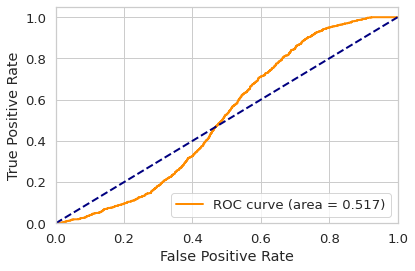

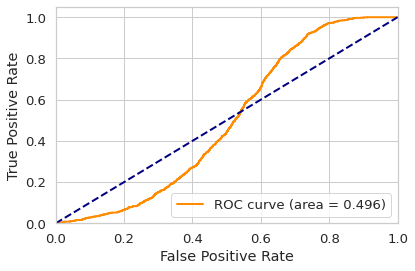

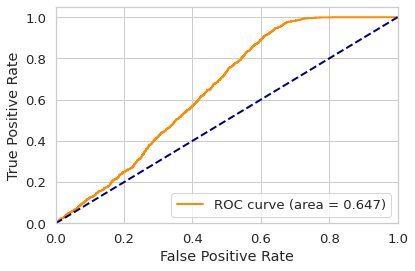

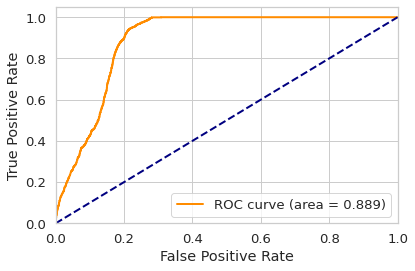

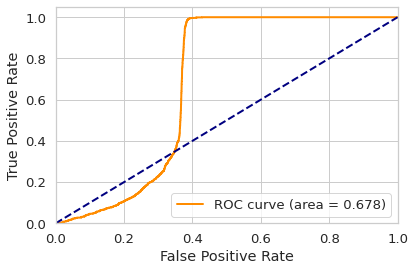

In [35]:
import sklearn.metrics as metrics
print(y_pred_score.shape)
print(y_pred_score[0])
print(ohe_y_test.shape)
ohe_y_test[0]
fpr0, tpr0, threshold0 = metrics.roc_curve(ohe_y_test[:,0], y_pred_score[:,0])
#tpr.shape
fig0 = plot_roc_curve(fpr0,tpr0,'Receiver Operating Characteristic Class Legit', auc_all_class[0], set_title = False)

fpr1, tpr1, threshold1 = metrics.roc_curve(ohe_y_test[:,1], y_pred_score[:,1])
fig1 = plot_roc_curve(fpr1,tpr1,'Receiver Operating Characteristic Class Stego-URL', auc_all_class[1], set_title = False)

fpr2, tpr2, threshold2 = metrics.roc_curve(ohe_y_test[:,2], y_pred_score[:,2])
fig2 = plot_roc_curve(fpr2,tpr2,'Receiver Operating Characteristic Class Stego-ETH', auc_all_class[2], set_title = False)

fpr3, tpr3, threshold3 = metrics.roc_curve(ohe_y_test[:,3], y_pred_score[:,3])
fig3 = plot_roc_curve(fpr3,tpr3,'Receiver Operating Characteristic Class Stego-HTML', auc_all_class[3], set_title = False)

fpr4, tpr4, threshold4 = metrics.roc_curve(ohe_y_test[:,4], y_pred_score[:,4])
fig4 = plot_roc_curve(fpr4,tpr4,'Receiver Operating Characteristic Class Stego-JS', auc_all_class[4], set_title = False)

fpr5, tpr5, threshold5 = metrics.roc_curve(ohe_y_test[:,5], y_pred_score[:,5])
fig5 = plot_roc_curve(fpr5,tpr5,'Receiver Operating Characteristic Class Stego-PS', auc_all_class[5], set_title = False)

fig0.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
fig4.tight_layout()
fig5.tight_layout()

fig0.savefig('./figure/roc_b64_class_legit.pdf')
fig1.savefig('./figure/roc_b64_class_stego_url.pdf')
fig2.savefig('./figure/roc_b64_class_stego_eth.pdf')
fig3.savefig('./figure/roc_b64_class_stego_html.pdf')
fig4.savefig('./figure/roc_b64_class_stego_js.pdf')
fig5.savefig('./figure/roc_b64_class_stego_ps.pdf')

In [29]:
#loading test set zip
test, num_test_legit, num_test_stego_for_class  = load_data(data_folder, "test_zip", legit_folder, stego_folders)
num_test_stego = np.sum(num_test_stego_for_class)
print("#test shape, neg, pos: ", test.shape, num_test_legit, num_test_stego)

#lsb extraction
#test = extract_k_lsb_features(test, k_lsb)
test = extract_1_lsb_features(test)

#create target
y_test = create_target_labels(num_test_legit, num_test_stego_for_class)
print("#num examples for class:")
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print("Apply OHE")
ohe_y_test = ohe_processer.transform(np.reshape(y_test,(-1,1))).toarray()
print("test set ready")

#legit images 2000
#stego images [1234, 1247, 1167, 1188, 1164]
data shape:  (8000, 512, 512, 3)
done
#test shape, neg, pos:  (8000, 512, 512, 3) 2000 6000
#num examples for class:
[[   0 2000]
 [   1 1234]
 [   2 1247]
 [   3 1167]
 [   4 1188]
 [   5 1164]]
Apply OHE
test set ready


In [30]:
y_pred_score = classifier.predict(test)

y_pred_label = np.around(y_pred_score, 0)

report_map = classification_report(y_test, np.argmax(y_pred_score, axis=1), output_dict=True)

acc_score = accuracy_score(ohe_y_test, y_pred_label)

auc_score = roc_auc_score(ohe_y_test, y_pred_score, multi_class="ovr", average="macro")

auc_score_pr = average_precision_score(ohe_y_test, y_pred_score)

result = str(acc_score)+";"+str(report_map['macro avg']['precision']) + ";" + str(
        report_map['macro avg']['recall']) + ";" + str(report_map['macro avg']['f1-score']) + ";" + str(
        auc_score)  + ";" + str(auc_score_pr)
 
print("acc;prec;rec;f1;auc;auc-pr")
print(result)

250/250 [==============================] - 42s 159ms/step
acc;prec;rec;f1;auc;auc-pr
0.486875;0.46882119619594764;0.4375588019232219;0.3237920820227253;0.7044973519504832;0.3575581211891427


/home/bmsa/env-max/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bmsa/env-max/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bmsa/env-max/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
auc_all_class = roc_auc_score(ohe_y_test, y_pred_score, multi_class="ovr", average=None)
print(auc_all_class)

[0.99975317 0.5172206  0.49612189 0.64738853 0.8889778  0.67752212]


In [32]:
auc_pr0 = average_precision_score(ohe_y_test[:,0], y_pred_score[:,0])
auc_pr1 = average_precision_score(ohe_y_test[:,1], y_pred_score[:,1])
auc_pr2 = average_precision_score(ohe_y_test[:,2], y_pred_score[:,2])
auc_pr3 = average_precision_score(ohe_y_test[:,3], y_pred_score[:,3])
auc_pr4 = average_precision_score(ohe_y_test[:,4], y_pred_score[:,4])
auc_pr5 = average_precision_score(ohe_y_test[:,5], y_pred_score[:,5])
print(str(auc_pr0)+" "+str(auc_pr1)+" "+str(auc_pr2)+" "+str(auc_pr3)+" "+str(auc_pr4)+" "+str(auc_pr5))

0.9996935599697561 0.14330612574177226 0.13895100826085421 0.19018558387690015 0.4855520243545556 0.1876604249310176


(8000, 6)
[9.6776652e-01 3.0016534e-02 2.1578926e-03 2.3035185e-05 1.1625248e-05
 2.4248444e-05]
(8000, 6)


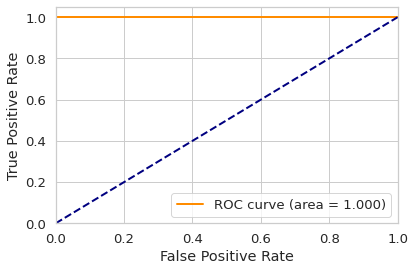

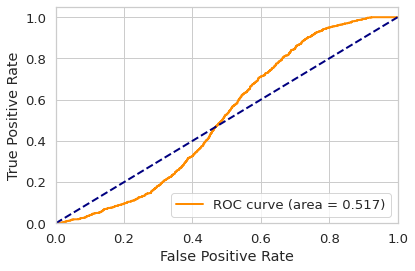

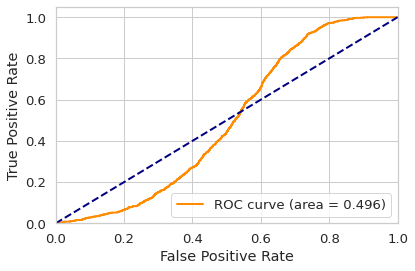

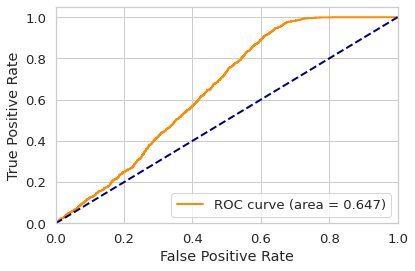

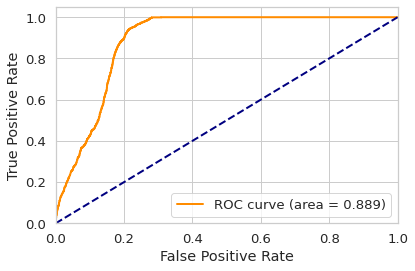

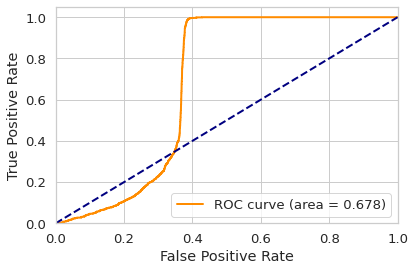

In [37]:
import sklearn.metrics as metrics
print(y_pred_score.shape)
print(y_pred_score[0])
print(ohe_y_test.shape)
ohe_y_test[0]
fpr0, tpr0, threshold0 = metrics.roc_curve(ohe_y_test[:,0], y_pred_score[:,0])
#tpr.shape
fig0 = plot_roc_curve(fpr0,tpr0,'Receiver Operating Characteristic Class Legit', auc_all_class[0], set_title = False)

fpr1, tpr1, threshold1 = metrics.roc_curve(ohe_y_test[:,1], y_pred_score[:,1])
fig1 = plot_roc_curve(fpr1,tpr1,'Receiver Operating Characteristic Class Stego-URL', auc_all_class[1], set_title = False)

fpr2, tpr2, threshold2 = metrics.roc_curve(ohe_y_test[:,2], y_pred_score[:,2])
fig2 = plot_roc_curve(fpr2,tpr2,'Receiver Operating Characteristic Class Stego-ETH', auc_all_class[2], set_title = False)

fpr3, tpr3, threshold3 = metrics.roc_curve(ohe_y_test[:,3], y_pred_score[:,3])
fig3 = plot_roc_curve(fpr3,tpr3,'Receiver Operating Characteristic Class Stego-HTML', auc_all_class[3], set_title = False)

fpr4, tpr4, threshold4 = metrics.roc_curve(ohe_y_test[:,4], y_pred_score[:,4])
fig4 = plot_roc_curve(fpr4,tpr4,'Receiver Operating Characteristic Class Stego-JS', auc_all_class[4], set_title = False)

fpr5, tpr5, threshold5 = metrics.roc_curve(ohe_y_test[:,5], y_pred_score[:,5])
fig5 = plot_roc_curve(fpr5,tpr5,'Receiver Operating Characteristic Class Stego-PS', auc_all_class[5], set_title = False)

fig0.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
fig4.tight_layout()
fig5.tight_layout()

fig0.savefig('./figure/roc_zip_class_legit.pdf')
fig1.savefig('./figure/roc_zip_class_stego_url.pdf')
fig2.savefig('./figure/roc_zip_class_stego_eth.pdf')
fig3.savefig('./figure/roc_zip_class_stego_html.pdf')
fig4.savefig('./figure/roc_zip_class_stego_js.pdf')
fig5.savefig('./figure/roc_zip_class_stego_ps.pdf')